<a href="https://colab.research.google.com/github/sudeozkanoglu/malaria_detect_deep_learning/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#KÜTÜPHANELERİ IMPORT ETME
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
import kagglehub
import shutil

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
# DATASET İNDİRME
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


In [ ]:
# TRAIN - VALIDATION VE TEST OLARAK DATASET'İ AYIRMA

# Ana klasör yolu
source_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Hedef klasörler
base_dir = '/kaggle/working/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Train/Val/Test oranları
train_split = 0.7
val_split = 0.15
test_split = 0.15

# İlk olarak hedef klasörleri oluştur
for split_dir in [train_dir, val_dir, test_dir]:
    for label in ['Parasitized', 'Uninfected']:
        os.makedirs(os.path.join(split_dir, label), exist_ok=True)

# Her sınıf için işlemler
for label in ['Parasitized', 'Uninfected']:
    img_dir = os.path.join(source_dir, label)
    images = os.listdir(img_dir)
    random.shuffle(images)

    total_images = len(images)
    train_count = int(train_split * total_images)
    val_count = int(val_split * total_images)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Kopyala
    for img_set, split_name in zip([train_images, val_images, test_images], ['train', 'val', 'test']):
        for img in img_set:
            src = os.path.join(img_dir, img)
            dst = os.path.join(base_dir, split_name, label, img)
            shutil.copyfile(src, dst)

print("Veri başarıyla train/val/test olarak bölündü!")

Veri başarıyla train/val/test olarak bölündü!


In [ ]:
# TRAIN - VALIDATION VE TEST KLASÖRLERİNİN İNCELENMESİ

# Bölünmüş verinin olduğu ana klasör
base_dir = '/kaggle/working/data'

# Train, val ve test klasörleri için
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} set:")
    for label in ['Parasitized', 'Uninfected']:
        folder = os.path.join(base_dir, split, label)
        count = len(os.listdir(folder))
        print(f"{label}: {count} görüntü")


TRAIN set:
Parasitized: 9646 görüntü
Uninfected: 9646 görüntü

VAL set:
Parasitized: 2067 görüntü
Uninfected: 2067 görüntü

TEST set:
Parasitized: 2067 görüntü
Uninfected: 2067 görüntü


In [ ]:
# EKSİK VERİLERİN KONTROLÜ

# 1. image_dataset_from_directory ile veri setlerini oluşturuyoruz

base_dir = '/kaggle/working/data'

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False  # Shuffle kapalı olsun ki index takip edelim
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

print("\nDatasets başarıyla oluşturuldu ✅")

# 2. Eksik veri kontrol fonksiyonu (batch destekli)

def check_missing(ds, name="dataset"):
    missing_image_count = 0
    missing_label_count = 0

    for i, (images, labels) in enumerate(ds):
        images_np = images.numpy()
        labels_np = labels.numpy()

        batch_size = images_np.shape[0]

        for j in range(batch_size):
            img = images_np[j]
            lbl = labels_np[j]

            if img.size == 0:
                print(f"[{name}] Eksik görsel - Batch {i}, Index {j}")
                missing_image_count += 1
            if lbl is None:
                print(f"[{name}] Eksik etiket - Batch {i}, Index {j}")
                missing_label_count += 1

    if missing_image_count == 0 and missing_label_count == 0:
        print(f"{name}: Eksik veri bulunamadı ✅")
    else:
        print(f"{name}: {missing_image_count} eksik görsel, {missing_label_count} eksik etiket ❗")

# 3. Datasetler için eksik veri kontrolü yapıyoruz

check_missing(train_ds, name="Train Seti")
check_missing(val_ds, name="Validation Seti")
check_missing(test_ds, name="Test Seti")

Found 19291 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.
Found 4133 files belonging to 2 classes.

Datasets başarıyla oluşturuldu ✅
Train Seti: Eksik veri bulunamadı ✅
Validation Seti: Eksik veri bulunamadı ✅
Test Seti: Eksik veri bulunamadı ✅


In [ ]:
# OUTLIER KONTROLÜ

# Outlier kontrolü fonksiyonu (batch destekli)
def check_outliers(ds, name="dataset"):
    small_image_count = 0
    bright_image_count = 0

    for i, (images, labels) in enumerate(ds):
        images_np = images.numpy()
        labels_np = labels.numpy()

        batch_size = images_np.shape[0]

        for j in range(batch_size):
            img = images_np[j]
            lbl = labels_np[j]

            # Şekil kontrolü (çok küçük görüntüler)
            if img.shape[0] < 20 or img.shape[1] < 20:
                print(f"[{name}] Küçük resim - Batch {i}, Index {j}, shape: {img.shape}")
                small_image_count += 1

            # Ortalama parlaklık kontrolü
            mean_brightness = np.mean(img)
            if mean_brightness < 5 or mean_brightness > 250:
                print(f"[{name}] Şüpheli parlaklık - Batch {i}, Index {j}, mean brightness: {mean_brightness:.2f}")
                bright_image_count += 1

    if small_image_count == 0 and bright_image_count == 0:
        print(f"{name}: Outlier bulunamadı ✅")
    else:
        print(f"{name}: {small_image_count} küçük resim ve {bright_image_count} şüpheli parlaklık bulundu ❗")

# Kullanım
check_outliers(train_ds, name="Train Seti")
check_outliers(val_ds, name="Validation Seti")
check_outliers(test_ds, name="Test Seti")

Train Seti: Outlier bulunamadı ✅
Validation Seti: Outlier bulunamadı ✅
Test Seti: Outlier bulunamadı ✅


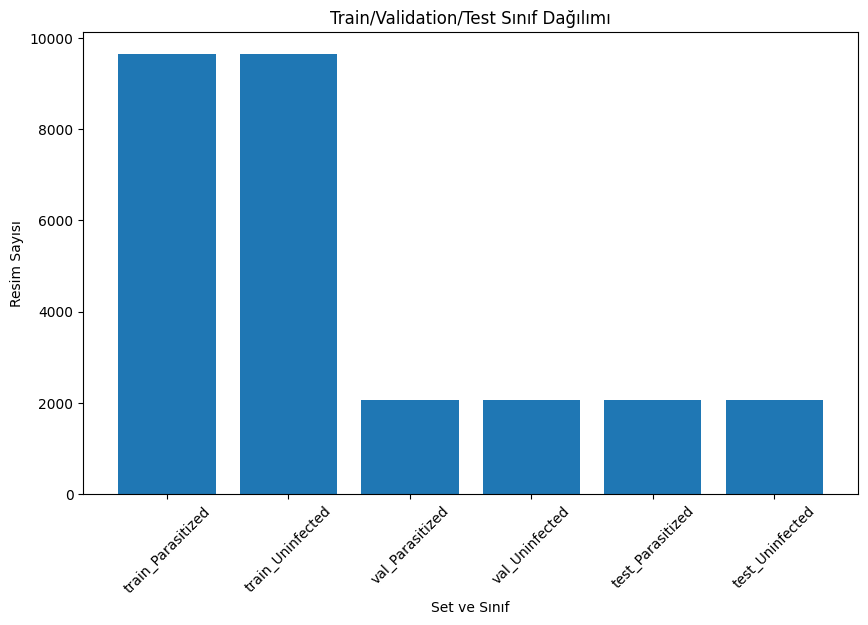

In [ ]:
# SINIF DAĞILIMI GRAFİĞİ - HİSTOGRAM

# Sınıf sayısını sayalım
labels = ['Parasitized', 'Uninfected']
counts = {}

for split in ['train', 'val', 'test']:
    for label in labels:
        folder = os.path.join(base_dir, split, label)
        count = len(os.listdir(folder))
        counts[f"{split}_{label}"] = count

# Histogram çizimi
plt.figure(figsize=(10,6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.xlabel('Set ve Sınıf')
plt.ylabel('Resim Sayısı')
plt.title('Train/Validation/Test Sınıf Dağılımı')
plt.show()

In [ ]:
#RANDOM SEED OLUŞTURMA
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#IMAGE VE BATCH SIZE BELİRLEME
IMAGE_SIZE = (224, 224)  # Transfer learning girişine göre görüntü boyutu
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# RESNET50

#IMAGE GENERATOR - RESNET50
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [ ]:
#GENERATOR FOR TRAIN, VALIDATION, TEST - RESNET50
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_resnet = valid_datagen_resnet.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19291 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4133 images belonging to 2 classes.


In [ ]:
#LOAD RESNET50
# ResNet50 modelini önceden eğitilmiş ağırlıklarla yükleyin
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
resnet_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
res_model = Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf
])

res_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
optimizer_res = Adam(learning_rate=0.001)

res_model.compile(
    optimizer=optimizer_res,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
res_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
res_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

res_history = res_model.fit(
    train_generator_resnet,
    epochs=EPOCHS,
    validation_data=valid_generator_resnet,
    callbacks=[res_early_stop, res_reduce_lr]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 269s 421ms/step - accuracy: 0.8404 - loss: 0.4031 - val_accuracy: 0.9175 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 241s 399ms/step - accuracy: 0.9127 - loss: 0.2247 - val_accuracy: 0.9192 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 402ms/step - accuracy: 0.9210 - loss: 0.2127 - val_accuracy: 0.9349 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 239s 396ms/step - accuracy: 0.9266 - loss: 0.2001 - val_accuracy: 0.9337 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 250s 415ms/step - accuracy: 0.9234 - loss: 0.2024 - val_accuracy: 0.9253 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 241s 400ms/step - accuracy: 0.9297 - loss: 0.1913 - val_accuracy: 0.9444 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 401ms/step - accura

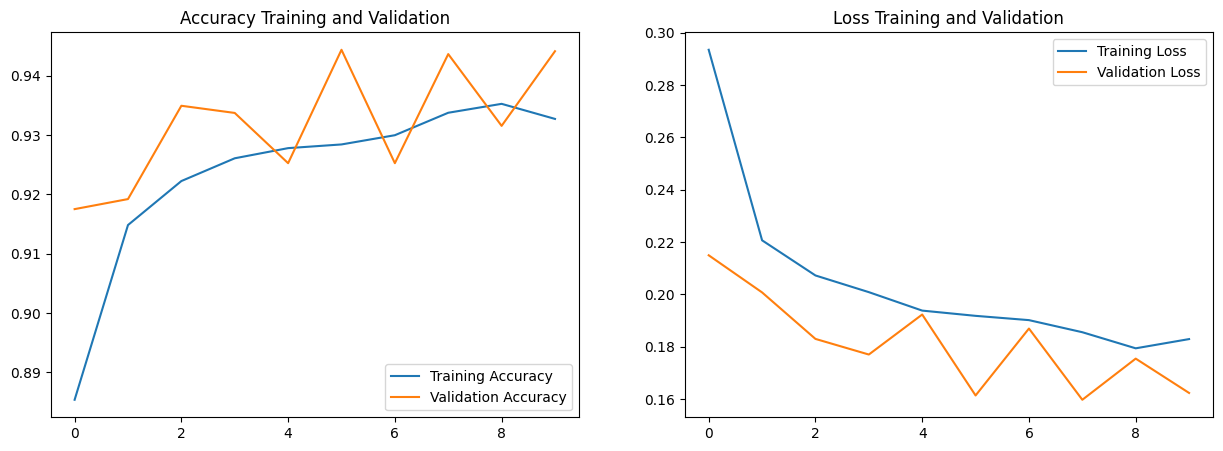

In [ ]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
acc_res = res_history.history['accuracy']
val_acc_res = res_history.history['val_accuracy']

loss_res = res_history.history['loss']
val_loss_res = res_history.history['val_loss']

epochs_range_res = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range_res, acc_res, label='Training Accuracy')
plt.plot(epochs_range_res, val_acc_res, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('RESNET50 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(epochs_range_res, loss_res, label='Training Loss')
plt.plot(epochs_range_res, val_loss_res, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('RESNET50 - Loss Training and Validation')
plt.show()

In [ ]:
# Get predictions - ResNet
test_generator_resnet.reset()
preds_res = res_model.predict(test_generator_resnet, verbose=1)
y_pred_res = np.argmax(preds_res, axis=1)
y_true_res = test_generator_resnet.classes

130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step


In [ ]:
# Get Class Name - ResNet
class_indices_res = test_generator_resnet.class_indices
class_names_res = list(class_indices_res.keys())

print('RESNET50 - Classification Report')
print(classification_report(y_true_res, y_pred_res, target_names=class_names_res))

Classification Report
              precision    recall  f1-score   support

 Parasitized       0.95      0.93      0.94      2067
  Uninfected       0.93      0.95      0.94      2066

    accuracy                           0.94      4133
   macro avg       0.94      0.94      0.94      4133
weighted avg       0.94      0.94      0.94      4133



In [ ]:
accuracy_res = accuracy_score(y_true_res, y_pred_res)
precision_res = precision_score(y_true_res, y_pred_res, average='macro')
recall_res = recall_score(y_true_res, y_pred_res, average='macro')
f1score_res = f1_score(y_true_res, y_pred_res, average='macro')

print('RESNET50')
print('--------------------------')
print('Accuracy:', accuracy_res)
print('Precision:', precision_res)
print('Recall:', recall_res)
print('F1-score:', f1score_res)

Accuracy: 0.9383014759254779
Precision: 0.9384118157122158
Recall: 0.938303404206891
F1-score: 0.9382977770479077


In [ ]:
# EFFICIENTNET

#IMAGE GENERATOR
train_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
#GENERATOR FOR TRAIN, VALIDATION, TEST
train_generator_efficient = train_datagen_efficient.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_efficient = valid_datagen_efficient.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_efficient = test_datagen_efficient.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19291 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4133 images belonging to 2 classes.


In [ ]:
#LOAD EfficientNetB0

# EfficientNetB0 modelini önceden eğitilmiş ağırlıklarla yükleyin
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
efficientnet_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficient_model = Sequential([
    efficientnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf
])

efficient_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
efficient_optimizer = Adam(learning_rate=0.001)

efficient_model.compile(
    optimizer=efficient_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
efficient_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
efficient_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

efficient_history = efficient_model.fit(
    train_generator_efficient,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[efficient_early_stop, efficient_reduce_lr]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 270s 406ms/step - accuracy: 0.8469 - loss: 0.3385 - val_accuracy: 0.8674 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 228s 379ms/step - accuracy: 0.9040 - loss: 0.2499 - val_accuracy: 0.9124 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 224s 371ms/step - accuracy: 0.9027 - loss: 0.2376 - val_accuracy: 0.9076 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 229s 381ms/step - accuracy: 0.9094 - loss: 0.2301 - val_accuracy: 0.9156 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 226s 376ms/step - accuracy: 0.9070 - loss: 0.2313 - val_accuracy: 0.9192 - val_loss: 0.1986 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 227s 376ms/step - accuracy: 0.9140 - loss: 0.2237 - val_accuracy: 0.9081 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 232s 385ms/step - accura

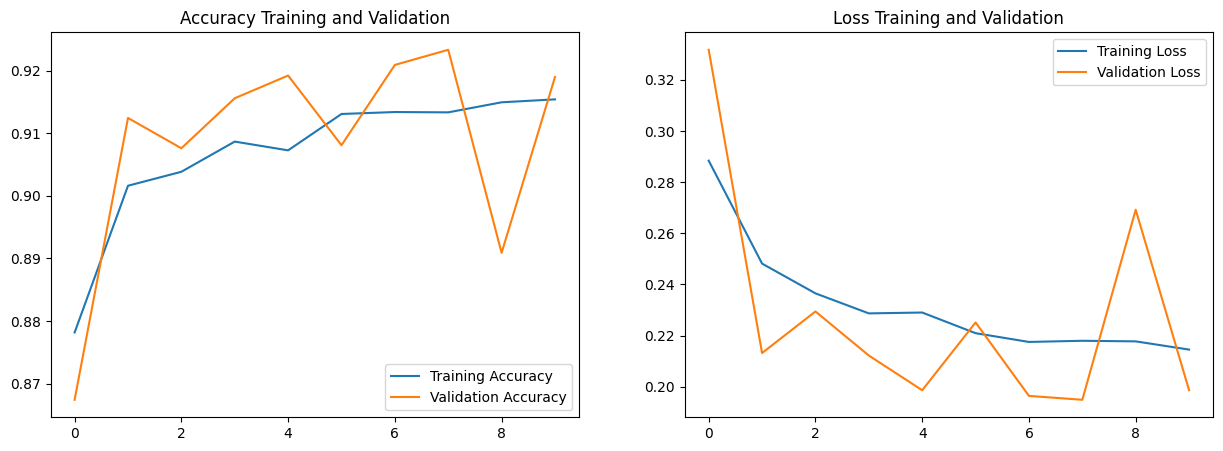

In [ ]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
efficient_acc = efficient_history.history['accuracy']
efficient_val_acc = efficient_history.history['val_accuracy']

efficient_loss = efficient_history.history['loss']
efficient_val_loss = efficient_history.history['val_loss']

efficient_epochs_range = range(len(efficient_acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(efficient_epochs_range, efficient_acc, label='Training Accuracy')
plt.plot(efficient_epochs_range, efficient_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('EFFICIENTNETB0 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(efficient_epochs_range, efficient_loss, label='Training Loss')
plt.plot(efficient_epochs_range, efficient_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('EFFICIENTNETB0- Loss Training and Validation')
plt.show()

In [ ]:
# Get predictions - EfficientNet
test_generator_efficient.reset()
efficient_preds = efficient_model.predict(test_generator_efficient, verbose=1)
y_pred_efficient = np.argmax(efficient_preds, axis=1)
y_true_efficient = test_generator_efficient.classes

130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step


In [ ]:
# Get Class Name - EfficientNet
class_indices_efficient = test_generator_efficient.class_indices
class_names_efficient = list(class_indices_efficient.keys())

print('EFFICIENTNETB0 - Classification Report')
print(classification_report(y_true_efficient, y_pred_efficient, target_names=class_names_efficient))

Classification Report
              precision    recall  f1-score   support

 Parasitized       0.96      0.71      0.82      2067
  Uninfected       0.77      0.97      0.86      2066

    accuracy                           0.84      4133
   macro avg       0.87      0.84      0.84      4133
weighted avg       0.87      0.84      0.84      4133



In [ ]:
accuracy_efficient = accuracy_score(y_true_efficient, y_pred_efficient)
precision_efficient = precision_score(y_true_efficient, y_pred_efficient, average='macro')
recall_efficient = recall_score(y_true_efficient, y_pred_efficient, average='macro')
f1score_efficient = f1_score(y_true_efficient, y_pred_efficient, average='macro')

print('EFFICIENTNETB0')
print('--------------------------')
print('Accuracy:', accuracy_efficient)
print('Precision:', precision_efficient)
print('Recall:', recall_efficient)
print('F1-score:', f1score_efficient)

Accuracy: 0.8403097023953545
Precision: 0.8664410138492841
Recall: 0.8403420083542095
F1-score: 0.8374200922059772


In [ ]:
# MOBILENET

#IMAGE GENERATOR
train_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
#GENERATOR FOR TRAIN, VALIDATION, TEST
train_generator_mobile = train_datagen_mobile.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_mobile = valid_datagen_mobile.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_mobile = test_datagen_mobile.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19291 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4133 images belonging to 2 classes.


In [ ]:
#LOAD MobileNetV2

# MobileNetV2 modelini önceden eğitilmiş ağırlıklarla yükleyin
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
mobilenet_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobile_model = Sequential([
    mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf
])

mobile_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
mobile_optimizer = Adam(learning_rate=0.001)

mobile_model.compile(
    optimizer=mobile_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
mobile_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mobile_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

mobile_history = mobile_model.fit(
    train_generator_mobile,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[mobile_early_stop, mobile_reduce_lr]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 243s 389ms/step - accuracy: 0.8372 - loss: 0.3796 - val_accuracy: 0.8970 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 225s 374ms/step - accuracy: 0.8863 - loss: 0.2772 - val_accuracy: 0.8786 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 225s 373ms/step - accuracy: 0.8919 - loss: 0.2755 - val_accuracy: 0.9001 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 222s 369ms/step - accuracy: 0.8890 - loss: 0.2666 - val_accuracy: 0.8737 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 266s 375ms/step - accuracy: 0.8980 - loss: 0.2531 - val_accuracy: 0.8471 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 224s 370ms/step - accuracy: 0.8989 - loss: 0.2477 - val_accuracy: 0.8911 - val_loss: 0.2553 - learning_rate: 5.0000e-04
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 224s 372ms/step - ac

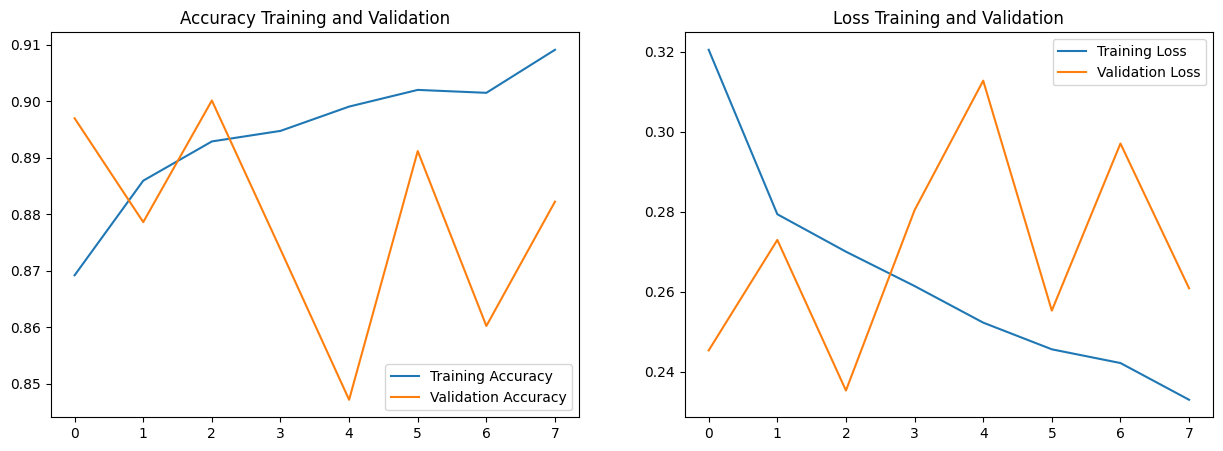

In [ ]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
mobile_acc = mobile_history.history['accuracy']
mobile_val_acc = mobile_history.history['val_accuracy']

mobile_loss = mobile_history.history['loss']
mobile_val_loss = mobile_history.history['val_loss']

mobile_epochs_range = range(len(mobile_acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mobile_epochs_range, mobile_acc, label='Training Accuracy')
plt.plot(mobile_epochs_range, mobile_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('MOBILENETV2 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(mobile_epochs_range, mobile_loss, label='Training Loss')
plt.plot(mobile_epochs_range, mobile_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('MOBILENETV2 - Loss Training and Validation')
plt.show()

In [ ]:
# Get predictions - MobileNet
test_generator_mobile.reset()
mobile_preds = mobile_model.predict(test_generator_mobile, verbose=1)
y_pred_mobile = np.argmax(mobile_preds, axis=1)
y_true_mobile = test_generator_mobile.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step


In [ ]:
# Get Class Name - MobileNet
class_indices_mobile = test_generator_mobile.class_indices
class_names_mobile = list(class_indices_mobile.keys())

print('MOBILENETV2 - Classification Report')
print(classification_report(y_true_mobile, y_pred_mobile, target_names=class_names_mobile))

Classification Report
              precision    recall  f1-score   support

 Parasitized       0.86      0.30      0.44      2067
  Uninfected       0.58      0.95      0.72      2066

    accuracy                           0.63      4133
   macro avg       0.72      0.63      0.58      4133
weighted avg       0.72      0.63      0.58      4133



In [ ]:
accuracy_mobile = accuracy_score(y_true_mobile, y_pred_mobile)
precision_mobile = precision_score(y_true_mobile, y_pred_mobile, average='macro')
recall_mobile = recall_score(y_true_mobile, y_pred_mobile, average='macro')
f1score_mobile = f1_score(y_true_mobile, y_pred_mobile, average='macro')

print('MOBILENETV2')
print('--------------------------')
print('Accuracy:', accuracy_mobile)
print('Precision:', precision_mobile)
print('Recall:', recall_mobile)
print('F1-score:', f1score_mobile)

Accuracy: 0.6252117106218243
Precision: 0.7182098475919363
Recall: 0.6252906621406502
F1-score: 0.5805967211031287
